### This file has code for implementation of Finite Difference Methods
    1. Explicit Finite-Difference Method (EFD)
    2. Implicit Finite Difference Method (IFD)
    3. Crank-Nicolson Finite Difference Method
    4. Feyman-Kac Theorem PDE implementation with above three methods

In [2]:
import numpy as np
from numpy import sqrt, log, sin, cos, exp, pi, mean, repeat, var, mat, floor, flip
from scipy.stats import norm
from scipy.sparse import diags
import matplotlib.pyplot as plt
from math import factorial as f
from datetime import date
from pandas import DataFrame
import pandas as pd
import matplotlib.pylab as pylab
import os

In [3]:

params = {'figure.titlesize': 'x-large',
        'legend.fontsize': 'x-large',
          'figure.figsize': (11, 3),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)



############# Ques 1 ####################
##Explicit FDM method for European Put price
def Eur_Put_Explicit_FDM (currentPrice, delta_x, delta_t, sigma, K, r, T):
    
    Pu = delta_t*( sigma**2/(2*delta_x**2) + (r-sigma**2/2)/(2*delta_x))
    Pm = 1- delta_t*(sigma**2/delta_x**2) - r*delta_t
    Pd = delta_t*( sigma**2/(2*delta_x**2) - (r-sigma**2/2)/(2*delta_x))
    
    #Creating A matrix with temporary range
    Smin_temp = 1
    Smax_temp = 20
    Xmin_temp = log(Smin_temp)
    Xmax_temp = log(Smax_temp)
    X_currentPrice = log(currentPrice)
    
    #to ensure X_currentPrice is in the stock price grid
    Xmin = X_currentPrice - (floor((X_currentPrice - Xmin_temp)/delta_x))*delta_x
    Xmax = X_currentPrice + (floor((Xmax_temp - X_currentPrice)/delta_x))*delta_x
    
    M = int((Xmax-Xmin)/delta_x)+1   #rows
    N = int(T/delta_t)+1           #column
 
    logStockPrice = np.linspace(Xmax, Xmin, M)
    logStockPrice = logStockPrice.reshape(M, 1)
    
           
    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense()
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, N-1] = K-exp(logStockPrice)  # Put option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    B = np.zeros((M, 1))
    B[M-1, 0] = exp(logStockPrice[M-2, 0]) - exp(logStockPrice[M-1, 0])
    
    for i in range(N-2, -1, -1):
        mat(F)[:, i] =  mat(A)*mat(F)[:, i+1] + B
        
    index = np.argmin(abs(logStockPrice[:, 0] - log(currentPrice)), axis=0)
    optionPrice = F[index, 0]
    return optionPrice
    

#Implicit FDM for European Put Price
def Eur_Put_Implicit_FDM (currentPrice, delta_x, delta_t, sigma, K, r, T):
    Pu = -0.5*delta_t*( sigma**2/(delta_x**2) + (r-sigma**2/2)/delta_x )
    Pm = 1 + delta_t*sigma**2/delta_x**2 + r*delta_t
    Pd = -0.5*delta_t*( sigma**2/(delta_x**2) - (r-sigma**2/2)/delta_x )
    
    
    #Creating A matrix with temporary range
    Smin_temp = 1
    Smax_temp = 20
    Xmin_temp = log(Smin_temp)
    Xmax_temp = log(Smax_temp)
    X_currentPrice = log(currentPrice)
    
    #to ensure X_currentPrice is in the stock price grid
    Xmin = X_currentPrice - (floor((X_currentPrice - Xmin_temp)/delta_x))*delta_x
    Xmax = X_currentPrice + (floor((Xmax_temp - X_currentPrice)/delta_x))*delta_x
    
    M = int((Xmax-Xmin)/delta_x)+1   #rows
    N = int(T/delta_t)+1           #column
 
    logStockPrice = np.linspace(Xmax, Xmin, M) #max to min decreasing
    logStockPrice = logStockPrice.reshape(M, 1)
           
    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense()
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    A[0, 0:3] = [1, -1, 0]
    A[M-1, M-3:M] = [0, 1, -1]
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, N-1] = K-exp(logStockPrice)  # Put option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    B = np.zeros((M, 1))
    
    for i in range(N-2, -1, -1):
        B[:, 0] = F[:, i+1]
        B[0, 0] = 0
        B[M-1, 0] = exp(logStockPrice[M-2, 0]) - exp(logStockPrice[M-1, 0])
        mat(F)[:, i] =  np.linalg.inv(mat(A))*B
        
    index = np.argmin(abs(logStockPrice[:, 0] - log(currentPrice)))
    optionPrice = F[index, 0]
    return optionPrice

#Crank-Nicolson FDM for European Put price
def Eur_Put_CN_FDM(currentPrice, delta_x, delta_t, sigma, K, r, T):
    Pu = -0.25*delta_t*(sigma**2/delta_x**2 + (r-sigma**2/2)/delta_x)
    Pm = 1 + delta_t*sigma**2/(2*delta_x**2) + r*delta_t/2
    Pd = -0.25*delta_t*(sigma**2/delta_x**2 - (r-sigma**2/2)/delta_x)
    
    #Creating A matrix with temporary range
    Smin_temp = 4
    Smax_temp = 16
    Xmin_temp = log(Smin_temp)
    Xmax_temp = log(Smax_temp)
    X_currentPrice = log(currentPrice)
    
    #to ensure X_currentPrice is in the stock price grid
    Xmin = X_currentPrice - (floor((X_currentPrice - Xmin_temp)/delta_x))*delta_x
    Xmax = X_currentPrice + (floor((Xmax_temp - X_currentPrice)/delta_x))*delta_x

    M = int((Xmax-Xmin)/delta_x)+1   #rows
    N = int(T/delta_t)+1           #column
 
    logStockPrice = np.linspace(Xmax, Xmin, M) #max to min decreasing
    logStockPrice = logStockPrice.reshape(M, 1)

    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense() #creating tridiagnol matrix
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    A[0, 0:3] = [1, -1, 0]
    A[M-1, M-3:M] = [0, 1, -1]
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, N-1] = K-exp(logStockPrice)  # Put option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    B = diags([-Pu, -(Pm-2), -Pd], [0, 1, 2], shape=(M-2, M)).todense() #creating tridiagnol matrix
    B = np.concatenate((B[0], B, B[M-2-1]), axis=0)
    B[0, :] = 0
    B[M-1, :] = 0
    
    C = np.zeros((M, 1))
    C[M-1, 0] = exp(logStockPrice[M-2, 0]) - exp(logStockPrice[M-1, 0])
    
    for i in range(N-2, -1, -1):
        #A*Fi = B*Fi+1 + C
        mat(F)[:, i] =  np.linalg.inv(mat(A))*( B*mat(F)[:, i+1] + C )
        
    index = np.argmin(abs(logStockPrice[:, 0] - log(currentPrice)))
    optionPrice = F[index, 0]
    return optionPrice
  

########## Inputs 
sigma = 0.2
r = 0.04
delta_t = 0.002
T = 0.5
K=10
delta_x = [sigma*sqrt(delta_t), sigma*sqrt(3*delta_t), sigma*sqrt(4*delta_t)]
currentPrice = np.arange(4, 16+1, 1)

##### Ques 1 Part 1

### Explicit FDM
Pa = DataFrame(np.zeros((currentPrice.shape[0], 3)), columns=['dX=sigma*sqrt(dt)', 'dX=sigma*sqrt(3dt)', 'dX=sigma*sqrt(4dt)'], index=currentPrice)
vExplicit_FDM = np.vectorize(Eur_Put_Explicit_FDM)
for i in range(3):
    Pa.iloc[:, i] = vExplicit_FDM(currentPrice, delta_x[i], delta_t, sigma, K, r, T)

### Implicit FDM
Pb = DataFrame(np.zeros((currentPrice.shape[0], 3)), columns=['dX=sigma*sqrt(dt)', 'dX=sigma*sqrt(3dt)', 'dX=sigma*sqrt(4dt)'], index=currentPrice)
vImplicit_FDM = np.vectorize(Eur_Put_Implicit_FDM)
for i in range(3):
    Pb.iloc[:, i] = vImplicit_FDM(currentPrice, delta_x[i], delta_t, sigma, K, r, T)

### Crank-Nicolson FDM
Pc = DataFrame(np.zeros((currentPrice.shape[0], 3)), columns=['dX=sigma*sqrt(dt)', 'dX=sigma*sqrt(3dt)', 'dX=sigma*sqrt(4dt)'], index=currentPrice)
vCN_FDM = np.vectorize(Eur_Put_CN_FDM)
for i in range(3):
    Pc.iloc[:, i] = vCN_FDM(currentPrice, delta_x[i], delta_t, sigma, K, r, T)
    

##### Ques 1 Part 2

def BS_Put(So, K, sigma, r, T):
    d1 = (log(So/K)+(r+sigma**2/2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    putPrice = norm.cdf(-d2)*K*exp(-r*T) - norm.cdf(-d1)*So
    return putPrice

vBS_Put = np.vectorize(BS_Put)
BS_PutPrice = vBS_Put(currentPrice, K, sigma, r, T)

Error_a = Pa.sub(BS_PutPrice, axis=0)
Error_b = Pb.sub(BS_PutPrice, axis=0)
Error_c = Pc.sub(BS_PutPrice, axis=0)


Text(0.5, 0.98, 'American Option Price with delta_S = 1.5')

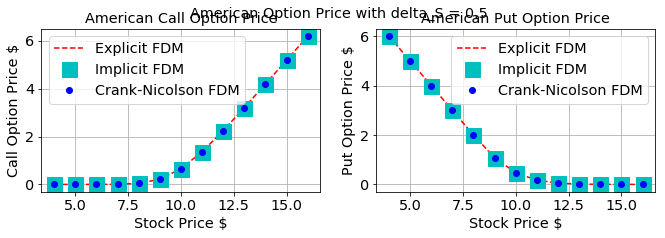

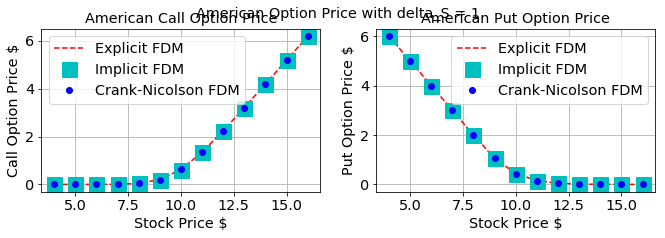

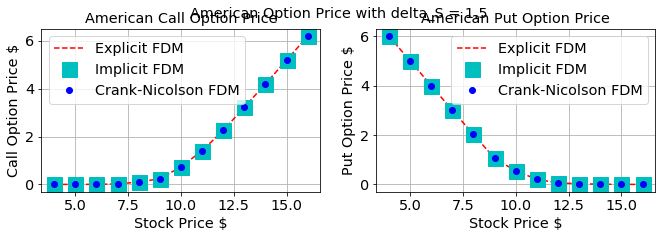

In [4]:

####################### Ques 2 #############################################

#American Call Explicit Finite Difference Method

def American_Call_Explicit_FDM(currentPrice, delta_s, delta_t, sigma, K, r, T):
    
    Smin = 0
    Smax = 30
    
    M = int((Smax-Smin)/delta_s)+1   #rows
    N = int(T/delta_t)+1           #column
 
    StockPrice = np.linspace(Smax, Smin, M)
    StockPrice = StockPrice.reshape(M, 1)
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, :] = StockPrice-K  # Call option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    j = np.arange(M-2, -1, -1) 
    Pu = delta_t*(r*j/2 + sigma**2*j**2/2)
    Pm = 1-delta_t*(sigma**2*j**2 + r)
    Pd = delta_t*(-r*j/2 + sigma**2*j**2/2)
     
    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense()
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    
    
    B = np.zeros((M, 1))
    B[0, 0] = StockPrice[0, 0] - StockPrice[1, 0]
    
    for i in range(N-2, -1, -1):
        temp =  mat(A)*mat(F)[:, i+1] + B
        mat(F)[:, i] = np.where(temp>mat(F)[:, i], temp, mat(F)[:, i])
        
    optionPrice = np.interp(currentPrice, flip(StockPrice[:, 0], axis=0), flip(F[:, 0], axis=0))
    return optionPrice

#American Put Explicit Finite Difference Method
def American_Put_Explicit_FDM(currentPrice, delta_s, delta_t, sigma, K, r, T):
    Smin = 0
    Smax = 30
    
    M = int((Smax-Smin)/delta_s)+1   #rows
    N = int(T/delta_t)+1           #column
 
    StockPrice = np.linspace(Smax, Smin, M)
    StockPrice = StockPrice.reshape(M, 1)
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, :] = K-StockPrice    # Put option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    j = np.arange(M-2, -1, -1) 
    Pu = delta_t*(r*j/2 + sigma**2*j**2/2)
    Pm = 1-delta_t*(sigma**2*j**2 + r)
    Pd = delta_t*(-r*j/2 + sigma**2*j**2/2)
     
    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense()
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    
    
    B = np.zeros((M, 1))
    B[M-1, 0] = StockPrice[M-2, 0] - StockPrice[M-1, 0]
    
    for i in range(N-2, -1, -1):
        temp =  mat(A)*mat(F)[:, i+1] + B
        mat(F)[:, i] = np.where(temp>mat(F)[:, i], temp, mat(F)[:, i])
        
    optionPrice = np.interp(currentPrice, flip(StockPrice[:, 0], axis=0), flip(F[:, 0], axis=0))
    return optionPrice


#American Call implicit Finite Difference Method
def American_Call_Implicit_FDM(currentPrice, delta_s, delta_t, sigma, K, r, T):
    Smin = 0
    Smax = 30
    
    M = int((Smax-Smin)/delta_s)+1   #rows
    N = int(T/delta_t)+1           #column
 
    StockPrice = np.linspace(Smax, Smin, M)
    StockPrice = StockPrice.reshape(M, 1)
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, :] = StockPrice-K  # Call option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    j = np.arange(M-2, -1, -1) 
    Pu = -0.5*delta_t*(sigma**2*j**2 + r*j)
    Pm = 1+delta_t*(sigma**2*j**2 + r)
    Pd = -0.5*delta_t*(sigma**2*j**2 - r*j)
     
    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense()
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    A[0, 0:3] = [1, -1, 0]
    A[M-1, M-3:M] = [0, 1, -1]
    
    
    B = np.zeros((M, 1))
       
    for i in range(N-2, -1, -1):
        B[:, 0] = F[:, i+1]
        B[0, 0] = StockPrice[0, 0] - StockPrice[1, 0]
        B[M-1, 0] = 0
        temp =  np.linalg.inv(mat(A))*B
        mat(F)[:, i] = np.where(temp>mat(F)[:, i], temp, mat(F)[:, i])
        
    optionPrice = np.interp(currentPrice, flip(StockPrice[:, 0], axis=0), flip(F[:, 0], axis=0))
    return optionPrice
    
    
    
#American put implicit Finite Difference Method
def American_Put_Implicit_FDM(currentPrice, delta_s, delta_t, sigma, K, r, T):
    Smin = 0
    Smax = 30
    
    M = int((Smax-Smin)/delta_s)+1   #rows
    N = int(T/delta_t)+1           #column
 
    StockPrice = np.linspace(Smax, Smin, M)
    StockPrice = StockPrice.reshape(M, 1)
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, :] = K-StockPrice  # Put option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    j = np.arange(M-2, -1, -1) 
    Pu = -0.5*delta_t*(sigma**2*j**2 + r*j)
    Pm = 1+delta_t*(sigma**2*j**2 + r)
    Pd = -0.5*delta_t*(sigma**2*j**2 - r*j)
     
    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense()
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    A[0, 0:3] = [1, -1, 0]
    A[M-1, M-3:M] = [0, 1, -1]
    
    
    B = np.zeros((M, 1))
       
    for i in range(N-2, -1, -1):
        B[:, 0] = F[:, i+1]
        B[0, 0] = 0
        B[M-1, 0] = StockPrice[M-2, 0] - StockPrice[M-1, 0]
        temp =  np.linalg.inv(mat(A))*B
        mat(F)[:, i] = np.where(temp>mat(F)[:, i], temp, mat(F)[:, i])
        
    optionPrice = np.interp(currentPrice, flip(StockPrice[:, 0], axis=0), flip(F[:, 0], axis=0))
    return optionPrice



#American Call Crank-Nicolson Finite Difference Method
def American_Call_CN_FDM(currentPrice, delta_s, delta_t, sigma, K, r, T):
    Smin = 0
    Smax = 30
    
    M = int((Smax-Smin)/delta_s)+1   #rows
    N = int(T/delta_t)+1           #column
 
    StockPrice = np.linspace(Smax, Smin, M)
    StockPrice = StockPrice.reshape(M, 1)
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, :] = StockPrice-K  # Call option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    j = np.arange(M-2, -1, -1) 
    Pu = -0.25*delta_t*(sigma**2*j**2 + r*j)
    Pm = 1+0.5*delta_t*(sigma**2*j**2 + r)
    Pd = -0.25*delta_t*(sigma**2*j**2 - r*j)
     
    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense()
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    A[0, 0:3] = [1, -1, 0]
    A[M-1, M-3:M] = [0, 1, -1]
    
    B = diags([-Pu, -(Pm-2), -Pd], [0, 1, 2], shape=(M-2, M)).todense() #creating tridiagnol matrix
    B = np.concatenate((B[0], B, B[M-2-1]), axis=0)
    B[0, :] = 0
    B[M-1, :] = 0

    C = np.zeros((M, 1))
    C[0, 0] = StockPrice[M-2, 0] - StockPrice[M-1, 0]
       
    for i in range(N-2, -1, -1):
        #A*Fi = B*Fi+1 + C
        temp =  np.linalg.inv(mat(A))*( B*mat(F)[:, i+1] + C )
        mat(F)[:, i] = np.where(temp>mat(F)[:, i], temp, mat(F)[:, i])
        
    optionPrice = np.interp(currentPrice, flip(StockPrice[:, 0], axis=0), flip(F[:, 0], axis=0))
    return optionPrice

#American Put Crank-Nicolson Finite Difference Method
def American_Put_CN_FDM(currentPrice, delta_s, delta_t, sigma, K, r, T):
    Smin = 0
    Smax = 30
    
    M = int((Smax-Smin)/delta_s)+1   #rows
    N = int(T/delta_t)+1           #column
 
    StockPrice = np.linspace(Smax, Smin, M)
    StockPrice = StockPrice.reshape(M, 1)
    
    F = mat(np.zeros((M, N))) #payoff matrix
    F[:, :] = K-StockPrice  # Put option payoff K-S at maturity
    F = np.where(F>0, F, 0)        # Max(K-S, 0) 
    
    j = np.arange(M-2, -1, -1) 
    Pu = -0.25*delta_t*(sigma**2*j**2 + r*j)
    Pm = 1+0.5*delta_t*(sigma**2*j**2 + r)
    Pd = -0.25*delta_t*(sigma**2*j**2 - r*j)
     
    A = diags([Pu, Pm, Pd], [0, 1, 2], shape=(M-2, M)).todense()
    A = np.concatenate((A[0], A, A[M-2-1]), axis=0)
    A[0, 0:3] = [1, -1, 0]
    A[M-1, M-3:M] = [0, 1, -1]
    
    B = diags([-Pu, -(Pm-2), -Pd], [0, 1, 2], shape=(M-2, M)).todense() #creating tridiagnol matrix
    B = np.concatenate((B[0], B, B[M-2-1]), axis=0)
    B[0, :] = 0
    B[M-1, :] = 0

    C = np.zeros((M, 1))
    C[M-1, 0]  = StockPrice[M-2, 0] - StockPrice[M-1, 0]
       
    for i in range(N-2, -1, -1):
        #A*Fi = B*Fi+1 + C
        temp =  np.linalg.inv(mat(A))*( B*mat(F)[:, i+1] + C )
        mat(F)[:, i] = np.where(temp>mat(F)[:, i], temp, mat(F)[:, i])
        
    optionPrice = np.interp(currentPrice, flip(StockPrice[:, 0], axis=0), flip(F[:, 0], axis=0))
    return optionPrice


### Inputs
sigma = 0.2
r = 0.04
delta_t = 0.002
T = 0.5
K=10
delta_s = [0.5, 1, 1.5]
currentPrice = np.arange(4, 16+1, 1)


### Explicit FDM (American Call and American Put)
American_ExplicitFDM = DataFrame(np.zeros((currentPrice.shape[0], 6)), columns=['Call_dS_0.5', 'Call_dS_1', 'Call_dS_1.5', 'Put_dS_0.5', 'Put_dS_1', 'Put_dS_1.5'], index=currentPrice)
vAmerican_Call_Explicit_FDM = np.vectorize(American_Call_Explicit_FDM)
for i in range(3):
    American_ExplicitFDM.iloc[:, i] = vAmerican_Call_Explicit_FDM(currentPrice, delta_s[i], delta_t, sigma, K, r, T)

vAmerican_Put_Explicit_FDM = np.vectorize(American_Put_Explicit_FDM)
for i in range(3):
    American_ExplicitFDM.iloc[:, i+3] = vAmerican_Put_Explicit_FDM(currentPrice, delta_s[i], delta_t, sigma, K, r, T)
       
    
### Implicit FDM (American Call and Put)
American_ImplicitFDM = DataFrame(np.zeros((currentPrice.shape[0], 6)), columns=['Call_dS_0.5', 'Call_dS_1', 'Call_dS_1.5', 'Put_dS_0.5', 'Put_dS_1', 'Put_dS_1.5'], index=currentPrice)
vAmerican_ImplicitFDM = np.vectorize(American_Call_Implicit_FDM)
for i in range(3):
    American_ImplicitFDM.iloc[:, i] = vAmerican_ImplicitFDM(currentPrice, delta_s[i], delta_t, sigma, K, r, T)

vAmerican_Put_Implicit_FDM = np.vectorize(American_Put_Implicit_FDM)
for i in range(3):
    American_ImplicitFDM.iloc[:, i+3] = vAmerican_Put_Implicit_FDM(currentPrice, delta_s[i], delta_t, sigma, K, r, T)
       
    
### Crank-Nicolson FDM (American Call and Put)
American_CN_FDM = DataFrame(np.zeros((currentPrice.shape[0], 6)), columns=['Call_dS_0.5', 'Call_dS_1', 'Call_dS_1.5', 'Put_dS_0.5', 'Put_dS_1', 'Put_dS_1.5'], index=currentPrice)
vAmerican_CN_FDM = np.vectorize(American_Call_CN_FDM)
for i in range(3):
    American_CN_FDM.iloc[:, i] = vAmerican_CN_FDM(currentPrice, delta_s[i], delta_t, sigma, K, r, T)

vAmerican_Put_CN_FDM = np.vectorize(American_Put_CN_FDM)
for i in range(3):
    American_CN_FDM.iloc[:, i+3] = vAmerican_Put_CN_FDM(currentPrice, delta_s[i], delta_t, sigma, K, r, T)
    
    
########Ques 2 part (ii) plotting
fig, axe = plt.subplots(1,2, sharex=True)
#fig.tight_layout(pad=0.5, w_pad=1.5, h_pad=2.0)
axe[0].plot(currentPrice, American_ExplicitFDM['Call_dS_0.5'], 'r--', label='Explicit FDM')
axe[0].plot(currentPrice, American_ImplicitFDM['Call_dS_0.5'], 'cs', markersize=15, label='Implicit FDM')
axe[0].plot(currentPrice, American_CN_FDM['Call_dS_0.5'], 'bo', label='Crank-Nicolson FDM')
axe[0].legend()
axe[0].grid()
axe[0].set_title("American Call Option Price")
axe[0].set_xlabel("Stock Price $")
axe[0].set_ylabel("Call Option Price $")

axe[1].plot(currentPrice, American_ExplicitFDM['Put_dS_0.5'], 'r--', label='Explicit FDM')
axe[1].plot(currentPrice, American_ImplicitFDM['Put_dS_0.5'], 'cs', markersize=15, label='Implicit FDM')
axe[1].plot(currentPrice, American_CN_FDM['Put_dS_0.5'], 'bo', label='Crank-Nicolson FDM')
axe[1].legend()
axe[1].grid()
axe[1].set_title("American Put Option Price")
axe[1].set_xlabel("Stock Price $")
axe[1].set_ylabel("Put Option Price $") 
fig.suptitle("American Option Price with delta_S = 0.5")   
       

fig, axe = plt.subplots(1,2, sharex=True)
axe[0].plot(currentPrice, American_ExplicitFDM['Call_dS_1'], 'r--', label='Explicit FDM')
axe[0].plot(currentPrice, American_ImplicitFDM['Call_dS_1'], 'cs', markersize=15, label='Implicit FDM')
axe[0].plot(currentPrice, American_CN_FDM['Call_dS_1'], 'bo', label='Crank-Nicolson FDM')
axe[0].legend()
axe[0].grid()
axe[0].set_title("American Call Option Price")
axe[0].set_xlabel("Stock Price $")
axe[0].set_ylabel("Call Option Price $")

axe[1].plot(currentPrice, American_ExplicitFDM['Put_dS_1'], 'r--', label='Explicit FDM')
axe[1].plot(currentPrice, American_ImplicitFDM['Put_dS_1'], 'cs', markersize=15, label='Implicit FDM')
axe[1].plot(currentPrice, American_CN_FDM['Put_dS_1'], 'bo', label='Crank-Nicolson FDM')
axe[1].legend()
axe[1].grid()
axe[1].set_title("American Put Option Price")
axe[1].set_xlabel("Stock Price $")
axe[1].set_ylabel("Put Option Price $")   
fig.suptitle("American Option Price with delta_S = 1") 


fig, axe = plt.subplots(1,2, sharex=True)
axe[0].plot(currentPrice, American_ExplicitFDM['Call_dS_1.5'], 'r--', label='Explicit FDM')
axe[0].plot(currentPrice, American_ImplicitFDM['Call_dS_1.5'], 'cs', markersize=15, label='Implicit FDM')
axe[0].plot(currentPrice, American_CN_FDM['Call_dS_1.5'], 'bo', label='Crank-Nicolson FDM')
axe[0].legend()
axe[0].grid()
axe[0].set_title("American Call Option Price")
axe[0].set_xlabel("Stock Price $")
axe[0].set_ylabel("Call Option Price $")

axe[1].plot(currentPrice, American_ExplicitFDM['Put_dS_1.5'], 'r--', label='Explicit FDM')
axe[1].plot(currentPrice, American_ImplicitFDM['Put_dS_1.5'], 'cs', markersize=15, label='Implicit FDM')
axe[1].plot(currentPrice, American_CN_FDM['Put_dS_1.5'], 'bo', label='Crank-Nicolson FDM')
axe[1].legend()
axe[1].grid()
axe[1].set_title("American Put Option Price")
axe[1].set_xlabel("Stock Price $")
axe[1].set_ylabel("Put Option Price $") 
fig.suptitle("American Option Price with delta_S = 1.5") 

